# Lecture 13 – Simple Linear Regression

**by Suraj Rampure**

Notebook credits:
- Ani Adhikari
- Data 8's textbook, chapter 15

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

### Correlation

First, let's come up with some examples of data to use in slides. (Normally this wouldn't be put in the notebook, but it might be of interest to you.)

Also, note here we use `np.corrcoef` here to compute the correlation coefficients, because we haven't yet defined what `r` is manually.

[[ 1.        -0.1206646]
 [-0.1206646  1.       ]]


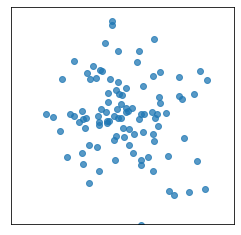

In [2]:
# Just noise
np.random.seed(43)
plt.figure(figsize = (4, 4))
plt.xticks([])
plt.yticks([])
plt.xlim(-3, 3)
plt.ylim(-3, 3)
x1, y1 = np.random.randn(2, 100)
plt.scatter(x1, y1, alpha = 0.75);
# plt.savefig('images/s1.png')
print(np.corrcoef(x1, y1))

[[1.         0.94882263]
 [0.94882263 1.        ]]


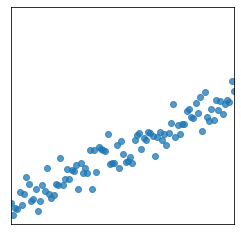

In [3]:
# Strong linear
np.random.seed(43)
plt.figure(figsize = (4, 4))
plt.xticks([])
plt.yticks([])
plt.xlim(-3, 3)
plt.ylim(-3, 3)
x2 = np.linspace(-3, 3, 100)
y2 = x2*0.5 - 1 + np.random.randn(100)*0.3
plt.scatter(x2, y2, alpha = 0.75);
# plt.savefig('images/s2.png')
print(np.corrcoef(x2, y2))

[[1.         0.05201679]
 [0.05201679 1.        ]]


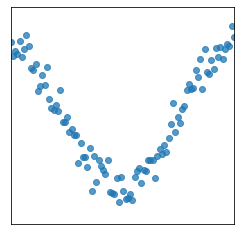

In [4]:
# Strong non-linear
np.random.seed(43)
plt.figure(figsize = (4, 4))
plt.xticks([])
plt.yticks([])
plt.xlim(-3, 3)
plt.ylim(-3, 3)
x3 = np.linspace(-3, 3, 100)
y3 = 2*np.sin(x3 - 1.5) + np.random.randn(100)*0.3
plt.scatter(x3, y3, alpha = 0.75);
# plt.savefig('images/s3.png')
print(np.corrcoef(x3, y3))

[[1.         0.70406276]
 [0.70406276 1.        ]]


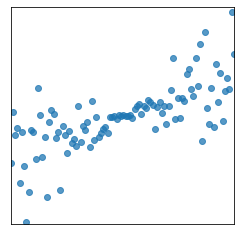

In [5]:
# Unequal spread
np.random.seed(43)
plt.figure(figsize = (4, 4))
plt.xticks([])
plt.yticks([])
plt.xlim(-3, 3)
plt.ylim(-3, 3)
x4 = np.linspace(-3, 3, 100)
y4 = x4/3 + np.random.randn(100)*(x4)/2.5
plt.scatter(x4, y4, alpha = 0.75);
# plt.savefig('images/s4.png')
print(np.corrcoef(x4, y4))

## Simple Linear Regression

First, let's implement the tools we'll need for regression.

In [6]:
def standard_units(x):
    return (x - np.mean(x)) / np.std(x)

def correlation(x, y):
    return np.mean(standard_units(x) * standard_units(y))

Let's read in our data.

In [7]:
df = pd.read_csv('galton.csv').iloc[:, 1:]

In [8]:
df

parent  child
0      70.5   61.7
1      68.5   61.7
2      65.5   61.7
3      64.5   61.7
4      64.0   61.7
..      ...    ...
923    69.5   73.7
924    69.5   73.7
925    69.5   73.7
926    69.5   73.7
927    69.5   73.7

[928 rows x 2 columns]

An interesting issue is that both our `parent` and `child` columns occur at fixed positions. We need to add some random noise, otherwise we'll suffer from gross overplotting.

In [9]:
df['parent'] = df['parent'] + np.random.randn(len(df))/2
df['child'] = df['child'] + np.random.randn(len(df))/2

In [10]:
fig = px.scatter(df, x= 'parent', y = 'child')
fig.show()

Using our `correlation` function:

In [11]:
correlation(df['parent'], df['child'])

0.44042226098613824

Using an in-built `correlation` function:

In [12]:
np.corrcoef(df['parent'], df['child'])

array([[1.        , 0.44042226],
       [0.44042226, 1.        ]])

In [13]:
df.corr()

parent     child
parent  1.000000  0.440422
child   0.440422  1.000000

All the same result.

What we now want to do is compute the **average $y$ for a given $x$**. A practical way to do this is to "bin" our x axis into 1-unit wide buckets, and then compute the average $y$ value for everything in that bucket. (We could choose bins of any width, though.)

In [14]:
def predict_mean_y(x):
    return df.loc[np.abs(df['parent'] - x) <= 0.5, 'child'].mean()

In [15]:
df['child_predicted'] = df['parent'].apply(predict_mean_y)

Now, let's look at our predictions:

In [16]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = df['parent'], y = df['child'], mode = 'markers', name = 'actual'))
fig.add_trace(go.Scatter(x = df['parent'], y = df['child_predicted'], mode = 'markers', name = 'predicted means', line=dict(color='gold')))
fig.update_layout(xaxis_title = 'MidParent Height', yaxis_title = 'Child Height')

Save for the tails where there are fewer values to draw from, it seems like our red predictions roughly follow a straight line piercing through the "middle" of our point cloud. That's our motivation for using a line to model this bivariate data.

Note: The cool thing about plotly is that you can hover over the points and it will tell you whether it is a prediction or actual value.

Now, it's time to implement the optimal coefficients.

In [17]:
def slope(x, y):
    return correlation(x, y) * np.std(y) / np.std(x)

def intercept(x, y):
    return np.mean(y) - slope(x, y)*np.mean(x)

In [18]:
ahat = intercept(df['parent'], df['child'])
bhat = slope(df['parent'], df['child'])

print("predicted y = {} + {} * average parent's height".format(np.round(ahat, 2), np.round(bhat, 2)))

predicted y = 26.51 + 0.61 * average parent's height


Let's see what our linear model looks like.

In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = df['parent'], y = df['child'], mode = 'markers', name = 'actual'))
fig.add_trace(go.Scatter(x = df['parent'], y = df['child_predicted'], mode = 'markers', name = 'predicted means', line=dict(color='gold')))
fig.add_trace(go.Scatter(x = df['parent'], y = ahat + bhat*df['parent'], name = 'linear model', line=dict(color='red')))


fig.update_layout(xaxis_title = 'MidParent Height', yaxis_title = 'Child Height')

## Visualizing Loss Surface

Let's look at what the loss surface for the above model looks like. Don't worry too much about what this code is doing.

In [20]:
def mse(y, yhat):
    return np.mean((y - yhat)**2)

In [21]:
# This function takes in our choice of [a, b] as a list, and returns
# the MSE for the corresponding linear model
def mse_for_height_model(t):
    a, b = t
    return mse(df['child'], a + b*df['parent'])

In [22]:
num_points = 200 # increase for better resolution, but it will run more slowly. 

# if (num_points <= 100):

uvalues = np.linspace(20, 32, num_points)
vvalues = np.linspace(-1, 3, num_points)
(u,v) = np.meshgrid(uvalues, vvalues)
thetas = np.vstack((u.flatten(),v.flatten()))

MSE = np.array([mse_for_height_model(t) for t in thetas.T])

loss_surface = go.Surface(x=u, y=v, z=np.reshape(MSE, u.shape))

opt_point = go.Scatter3d(x = [ahat], y = [bhat], z = [mse_for_height_model((ahat, bhat))],
            mode = 'markers', name = 'optimal parameters',
            marker=dict(size=10, color='gold'))

fig = go.Figure(data=[loss_surface])
fig.add_trace(opt_point)

fig.update_layout(scene = dict(
    xaxis_title = "theta0",
    yaxis_title = "theta1",
    zaxis_title = "MSE"))


fig.show()
# else:
#     print("Picking num points > 100 can be really slow. If you really want to try, edit the code above so that this if statement doesn't trigger.")

As you can see, our choice of $\hat{a}, \hat{b}$ truly do minimize mean squared error. They exist at the minimum value of the loss surface.

## Multiple Linear Regression

Let's load in a new dataset. This is aggregate per-player data from the 2018-19 NBA season.

In [23]:
nba = pd.read_csv('nba18-19.csv')

In [24]:
nba

Rk                  Player Pos  Age   Tm   G  GS    MP   FG   FGA  ...  \
0      1  Álex Abrines\abrinal01  SG   25  OKC  31   2  19.0  1.8   5.1  ...   
1      2      Quincy Acy\acyqu01  PF   28  PHO  10   0  12.3  0.4   1.8  ...   
2      3  Jaylen Adams\adamsja01  PG   22  ATL  34   1  12.6  1.1   3.2  ...   
3      4  Steven Adams\adamsst01   C   25  OKC  80  80  33.4  6.0  10.1  ...   
4      5   Bam Adebayo\adebaba01   C   21  MIA  82  28  23.3  3.4   5.9  ...   
..   ...                     ...  ..  ...  ...  ..  ..   ...  ...   ...  ...   
703  528  Tyler Zeller\zellety01   C   29  MEM   4   1  20.5  4.0   7.0  ...   
704  529    Ante Žižić\zizican01   C   22  CLE  59  25  18.3  3.1   5.6  ...   
705  530   Ivica Zubac\zubaciv01   C   21  TOT  59  37  17.6  3.6   6.4  ...   
706  530   Ivica Zubac\zubaciv01   C   21  LAL  33  12  15.6  3.4   5.8  ...   
707  530   Ivica Zubac\zubaciv01   C   21  LAC  26  25  20.2  3.8   7.2  ...   

       FT%  ORB  DRB  TRB  AST  STL  BLK  TOV   PF   PTS  
0    0.923  0.2  1.4  1.5  0.6  0.5  0.2  0.5  1.7   5.3  
1    0.700  0.3  2.2  2.5  0.8  0.1  0.4  0.4  2.4   1.7  
2    0.778  0.3  1.4  1.8  1.9  0.4  0.1  0.8  1.3   3.2  
3    0.500  4.9  4.6  9.5  1.6  1.5  1.0  1.7  2.6  13.9  
4    0.735  2.0  5.3  7.3  2.2  0.9  0.8  1.5  2.5   8.9  
..     ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  
703  0.778  2.3  2.3  4.5  0.8  0.3  0.8  1.0  4.0  11.5  
704  0.705  1.8  3.6  5.4  0.9  0.2  0.4  1.0  1.9   7.8  
705  0.802  1.9  4.2  6.1  1.1  0.2  0.9  1.2  2.3   8.9  
706  0.864  1.6  3.3  4.9  0.8  0.1  0.8  1.0  2.2   8.5  
707  0.733  2.3  5.3  7.7  1.5  0.4  0.9  1.4  2.5   9.4  

[708 rows x 30 columns]

Let's suppose our goal is to predict the number of points someone averaged (`PTS`; this is our dependent variable). The independent variables we'll use are
- `AST`, the average number of assists per game, and
- `3PA`, the number of 3 point field goals attempted per game

In [25]:
nba[['AST', '3PA', 'PTS']]

AST  3PA   PTS
0    0.6  4.1   5.3
1    0.8  1.5   1.7
2    1.9  2.2   3.2
3    1.6  0.0  13.9
4    2.2  0.2   8.9
..   ...  ...   ...
703  0.8  0.0  11.5
704  0.9  0.0   7.8
705  1.1  0.0   8.9
706  0.8  0.0   8.5
707  1.5  0.0   9.4

[708 rows x 3 columns]

First, let's explore and fit a model using just `AST`.

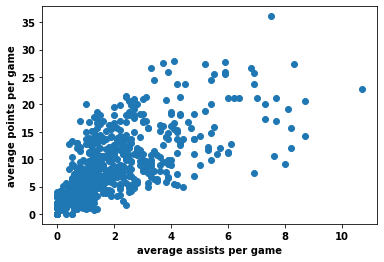

In [26]:
plt.scatter(nba['AST'], nba['PTS'])
plt.xlabel('average assists per game')
plt.ylabel('average points per game');

In [27]:
r_nba = correlation(nba['AST'], nba['PTS'])
r_nba

0.676021856744927

The correlation between `AST` and `PTS` is relativelty strong. However, the scatter plot above tells us this isn't exactly the optimal setting in which to perform linear regression. For the purposes of illustration, we'll continue with it anyways.

In [28]:
ahat_nba = intercept(nba['AST'], nba['PTS'])
bhat_nba = slope(nba['AST'], nba['PTS'])

print("predicted PTS = {} + {} * AST".format(np.round(ahat_nba, 2), np.round(bhat_nba, 2)))

predicted PTS = 3.98 + 2.4 * AST


Let's take a look at our prediction:

In [29]:
pred_ast_only = ahat_nba + bhat_nba*nba['AST']

In [30]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = nba['AST'], y = nba['PTS'], mode = 'markers', name = 'actual'))
fig.add_trace(go.Scatter(x = nba['AST'], y = pred_ast_only, name = 'predictions', line=dict(color='red')))


fig.update_layout(xaxis_title = 'AST', yaxis_title = 'PTS')

Our model does _okay_. Let's compute the RMSE (that is, the square root of the mean squared error; we take the square root so that the RMSE is in the same units as our $y$ values). We will use this as a baseline for when we add more indepedent variables.

In [31]:
def rmse(y, yhat):
    return mse(y, yhat)**0.5

In [32]:
rmse_ast_only = rmse(nba['PTS'], pred_ast_only)

In [33]:
rmse_ast_only

4.291659114148547

There's still a ton of variation in our model. Let's see if we can do better, by incorporating `3PA` as well (that is, the average number of 3 point shot attempts they made per game).

Specifically, we're looking to create the model

$$\text{predicted PTS} = \theta_0 + \theta_1 \cdot \text{AST} + \theta_2 \cdot \text{3PA}$$

In orrder to do this, we're going to import a new library, called `sklearn`. Don't worry too much about what it's doing for now – we will dedicate an entire section of lecture to it in 2 lectures from now.

In [34]:
import sklearn.linear_model as lm

In [35]:
model = lm.LinearRegression(fit_intercept = True)

model.fit(nba[['AST', '3PA']], nba['PTS']);

In [36]:
model.coef_

array([1.64065507, 1.25758096])

In [37]:
model.intercept_

2.156347047514834

The above outputs tell us that the parameters that minimize MSE for this model are
- $\theta_0 = 2.1563$
- $\theta_1 = 1.6407$
- $\theta_2 = 1.2576$

Meaning our predictions should be of the form

$$\text{predicted PTS} = 2.1563 + 1.6407 \cdot \text{AST} + 1.2576 \cdot \text{3PA}$$

Let's visualize what our model and predictions look like.

In [38]:
pred_ast_3pa = model.predict(nba[['AST', '3PA']])

In [39]:
fig = go.Figure()

nba_data_raw = go.Scatter3d(x = nba['AST'], y = nba['3PA'], z = nba['PTS'],
            mode = 'markers', marker=dict(color='cornflowerblue', size = 5), name = 'actual')

num_points = 100
xvalues = np.linspace(0, 11, num_points)
yvalues = np.linspace(0, 10, num_points)
(u,v) = np.meshgrid(xvalues, yvalues)
ast3pa = np.vstack((u.flatten(),v.flatten()))

pred_pts = np.array([model.predict(coord.reshape(1, -1)) for coord in ast3pa.T])

loss_surface = go.Surface(x=u, y=v, z=np.reshape(pred_pts, u.shape), name = 'predicted')

# prediction_surface = go.Scatter3d(x = nba['AST'], y = nba['3PA'], z = pred_ast_3pa, line = dict(color='gold'),
#                                  mode = 'markers')

fig.add_trace(loss_surface)
fig.add_trace(nba_data_raw)

fig.update_layout(scene = dict(
    xaxis_title = "AST",
    yaxis_title = "3PA",
    zaxis_title = "PTS"))

fig.show()

Instead of our model being a line, it is now a plane in 3D (the colorful surface above). The blue points above are the true `PTS` values.

It's sometimes hard to interpret things in 3D; we can also visualize in 2D.

In [40]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = nba['AST'], y = nba['PTS'], mode = 'markers', name = 'actual'))
fig.add_trace(go.Scatter(x = nba['AST'], y = pred_ast_only, name = 'lm AST only', line=dict(color='red')))
fig.add_trace(go.Scatter(x = nba['AST'], y = pred_ast_3pa, mode = 'markers', name = 'lm AST 3PA', line=dict(color='gold')))


fig.update_layout(xaxis_title = 'average assists per game', yaxis_title = 'points per game')

The yellow dots are the result of our updated linear model. It doesn't look linear here, because it is not solely a function of assists per game. (It was linear in the 3D figure above.) The yellow points here all lie on the colorful plane above.

We can also scatter our predicted values vs. our actual values.

In [41]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = nba['PTS'], y = pred_ast_only, mode = 'markers', name = 'lm AST only', line=dict(color='red')))
fig.add_trace(go.Scatter(x = nba['PTS'], y = pred_ast_3pa, mode = 'markers', name = 'lm AST 3PA', line=dict(color='gold')))


fig.update_layout(xaxis_title = 'actual points per game', yaxis_title = 'predicted points per game')

Let's also look at our RMSE.

In [42]:
pred_ast_3pa = model.predict(nba[['AST', '3PA']])

rmse_ast_3pa = rmse(nba['PTS'], pred_ast_3pa)
rmse_ast_3pa

3.6427935954265114

It's noticably lower than before!

In [43]:
rmse_ast_only

4.291659114148547

## Multiple $R^2$

In [44]:
r2_ast_only = np.var(pred_ast_only) / np.var(nba['PTS'])
r2_ast_3pa = np.var(pred_ast_3pa) / np.var(nba['PTS'])

In [45]:
r2_ast_only

0.4570055507968577

In [46]:
correlation(pred_ast_only, nba['PTS'])**2

0.4570055507968592

In [47]:
r2_ast_3pa

0.608786276366571

In [48]:
correlation(pred_ast_3pa, nba['PTS'])**2

0.6087862763665716

This means that our model that only uses `AST` can explain 45% of the variation of the true observations (`PTS` values), while our model that uses `AST` and `3PA` can explain 60% of the variation. 